# SALES PERFOMANCE OF VIDEO GAMES

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns


### LOAD CSV FILE

In [89]:
df = pd.read_csv('Video_Games.csv')

In [90]:
df.shape[0]

16719

### EXPLORATORY ANALYSIS AND DATA CLEANING

In [96]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher             2
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [97]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
df[df['Publisher'].isna()]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
659,NaN,GEN,1993.0,NaN,NaN,1.78,0.53,0.00,0.08,2.39,NaN,NaN,NaN,NaN,NaN,NaN
14246,NaN,GEN,1993.0,NaN,NaN,0.00,0.00,0.03,0.00,0.03,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# i made a function to fill missing values with the mode
def fill_missing_with_mode(series):
    mode = series.mode()  # Get the mode of the series
    if not mode.empty:    # If mode exists, it is used
        return series.fillna(mode.iloc[0])
    return series       

# Group by 'Platform' and 'Publisher' and apply the function
df['Publisher'] = df.groupby(['Platform', 'Genre'])['Publisher'].transform(fill_missing_with_mode)

print(df['Publisher'].isnull().sum())


2


In [100]:
rows_to_drop = [659,14246]
df = df.drop(index=rows_to_drop)

# Confirm the rows were removed
print(f"Remaining rows: {df.shape[0]}")


Remaining rows: 16717


In [101]:
# Find columns containing the string 'tbd'
columns_with_tbd = [col for col in df.columns if df[col].astype(str).str.contains('tbd').any()]

print("Columns with 'tbd':", columns_with_tbd)


Columns with 'tbd': ['User_Score']


In [102]:
for col in columns_with_tbd:
    df[col] = df[col].replace('tbd', 0)  # Replace '0' with an appropriate value


### Encoding the Categorical values so as to create a corelation plot to view corelation

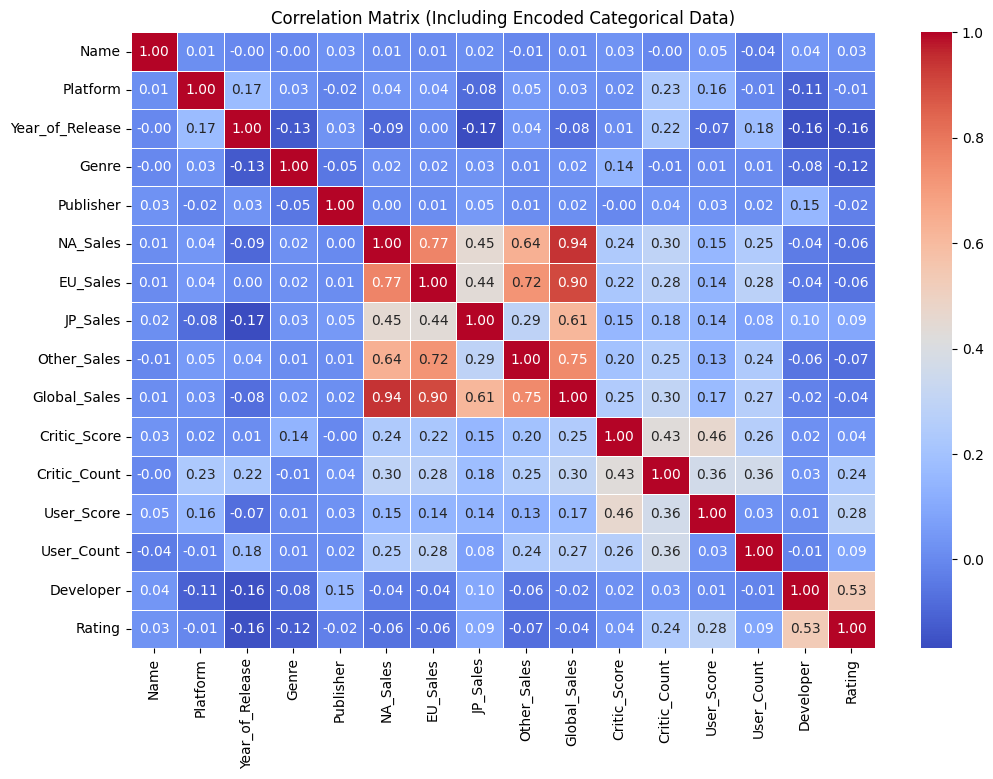

In [103]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the DataFrame for encoding
df_encoded = df.copy()

# Encode categorical columns
for col in ['Genre', 'Platform', 'Publisher', 'Name', 'Rating', 'Developer']:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Compute correlation matrix with encoded data
correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Including Encoded Categorical Data)")
plt.show()


### Created a function to fill missing numerical values

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def fill_and_encode_missing_values(df, target_col, feature_cols):
    df_copy = df.copy()
    
    # Mask for tracking original missing values in target column
    missing_mask = df_copy[target_col].isnull()

    label_encoders = {}
    for col in feature_cols + [target_col]:  # Include target column for encoding if needed
        if df_copy[col].dtype == 'object' or df_copy[col].dtype.name == 'category':
            df_copy[col] = df_copy[col].fillna('missing')  # Temporarily fill missing with 'missing'
            encoder = LabelEncoder()
            df_copy[col] = encoder.fit_transform(df_copy[col].astype(str))
            label_encoders[col] = encoder

    # Spliting the data into training and testing sets for prediction
    train_data = df_copy[~missing_mask]  # Exclude rows where target is missing
    test_data = df_copy[missing_mask]    # Only rows where target is missing

    # If no test data, return the original DataFrame (no missing values to predict)
    if test_data.empty:
        return df

    # Features for model training
    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    X_test = test_data[feature_cols]

    # Train the regression model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict missing values
    predicted_values = model.predict(X_test)
    
    if target_col in label_encoders:
        predicted_values = label_encoders[target_col].inverse_transform(predicted_values.astype(int))

    # Fill the missing values in the original DataFrame with predictions
    df.loc[missing_mask, target_col] = predicted_values

    return df


In [105]:
# Defining the target column and feature columns
target_column = 'Year_of_Release'
feature_columns = ['Genre', 'Platform', 'Publisher', 'Global_Sales', 'User_Score']

# Calling the function to fill missing values
df = fill_and_encode_missing_values(df, target_column, feature_columns)


In [106]:
df.isna().sum()

Name                  0
Platform              0
Year_of_Release       0
Genre                 0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8580
Critic_Count       8580
User_Score         6702
User_Count         9127
Developer          6621
Rating             6767
dtype: int64

In [107]:
# Define the target column and feature columns
target_column = 'Critic_Score'
feature_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales', 'Other_Sales']

# Call the function to fill missing values
df = fill_and_encode_missing_values(df, target_column, feature_columns)

In [108]:
# Define the target column and feature columns
target_column = 'Critic_Count'
feature_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales', 'Other_Sales']

# Call the function to fill missing values
df = fill_and_encode_missing_values(df, target_column, feature_columns)

In [109]:
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')

In [110]:
# Define the target column and feature columns
target_column = 'User_Score'
feature_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales', 'Other_Sales']

# Call the function to fill missing values
df = fill_and_encode_missing_values(df, target_column, feature_columns)

In [112]:
df.isna().sum()

Name                  0
Platform              0
Year_of_Release       0
Genre                 0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score          0
Critic_Count          0
User_Score            0
User_Count         9127
Developer          6621
Rating             6767
dtype: int64

In [113]:
# Define the target column and feature columns
target_column = 'User_Count'
feature_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales', 'Other_Sales']

# Call the function to fill missing values
df = fill_and_encode_missing_values(df, target_column, feature_columns)

### Created a function to fill missing Categorical Values

In [114]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

def predict_missingcat_values(df, columns_to_fill, columns_for_training):
    # Make a copy of the original DataFrame
    df2 = df.copy()

    # Handle missing values by replacing NaN in specified columns
    for col in columns_to_fill:
        df2[col] = df2[col].fillna('missing')

    # Encode categorical features
    label_encoders = {}
    for col in columns_to_fill + columns_for_training:
        le = LabelEncoder()
        df2[col] = le.fit_transform(df2[col].astype(str))
        label_encoders[col] = le  # Save encoder for each column

    # Split the data into training and testing sets based on the columns to fill
    train_data = df2[df2[columns_to_fill[0]] != label_encoders[columns_to_fill[0]].transform(['missing'])[0]]  # Exclude 'missing'
    test_data = df2[df2[columns_to_fill[0]] == label_encoders[columns_to_fill[0]].transform(['missing'])[0]]  # Only 'missing'

    # Prepare training features and target
    X_train = train_data[columns_for_training]
    y_train = train_data[columns_to_fill]
    X_test = test_data[columns_for_training]

    # Train the regression model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict missing values
    predicted_values = model.predict(X_test)

    # Map predicted labels back to original values for each column in columns_to_fill
    for i, col in enumerate(columns_to_fill):
        df.loc[df[col].isnull(), col] = label_encoders[col].inverse_transform(predicted_values.astype(int))

    return df


In [115]:
df = predict_missingcat_values(df, columns_to_fill=['Developer'], columns_for_training=['NA_Sales', 'JP_Sales', 'Publisher', 'Platform'])


C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [116]:
df = predict_missingcat_values(df, columns_to_fill=['Rating'], columns_for_training=['Developer', 'User_Score', 'Year_of_Release', 'Critic_Count'])


C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [117]:
df.isna().sum()

Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Critic_Score       0
Critic_Count       0
User_Score         0
User_Count         0
Developer          0
Rating             0
dtype: int64

<Axes: >

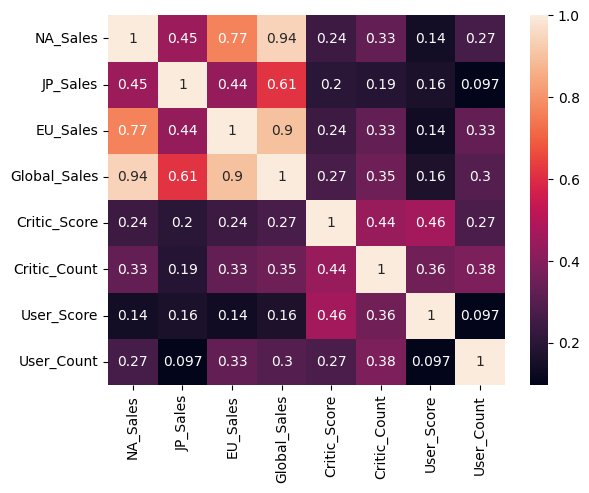

In [118]:
column_list = ["NA_Sales", "JP_Sales", "EU_Sales", "Global_Sales", "Critic_Score", "Critic_Count", "User_Score", "User_Count"]
sns.heatmap(df[column_list].corr(), annot = True)

### Building a function that creates a model and trains the model to predict global sales based on single input feature

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_to_global_sales(df, input_feature):
    # Extract the input feature
    x = df[input_feature]
    y = df["Global_Sales"]
    x = x.to_numpy().reshape(-1, 1)  # Reshaping to make it 2D for scikit-learn

    # Splits the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    print("There are %d data points in the training set." % len(x_train))
    print("There are %d data points in the testing set." % len(x_test))

    # Standardizing the input feature
    scaler = StandardScaler()
    scaler.fit(x)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Trains a linear regression model
    model = LinearRegression()
    model.fit(x_train_scaled, y_train)

    # Get the gradient (slope) and intercept
    gradient = model.coef_[0]
    intercept = model.intercept_

    print("Gradient (slope): ", gradient)
    print("Intercept: ", intercept)

    # Makes predictions on the test set
    predictions = model.predict(x_test_scaled)

    # Calculates the mean absolute error
    mean_abs = mean_absolute_error(y_test, predictions)
    # Calculates the mean squared error
    mean_squared = mean_squared_error(y_test, predictions)
    rms_error = np.sqrt(mean_squared)
    # Calculates the R2 score
    R2 = r2_score(y_test, predictions)

    # Printsthe results of these metrics
    print("Mean absolute error: ", mean_abs)
    print("Mean squared error: ", mean_squared)
    print("Root mean squared error: ", rms_error)
    print("R2: ", R2)

    # Prepares a range of x values for plotting the regression line
    x_fit = np.arange(0, 40, 0.01).reshape(-1, 1)
    x_fit_scaled = scaler.transform(x_fit)
    y_fit = model.predict(x_fit_scaled)

    # Plotting the data and the regression line
    sns.scatterplot(data=df, x=input_feature, y="Global_Sales")
    plt.plot(x_fit, y_fit, color='red')  # Plot the regression line in red
    plt.xlabel(input_feature)
    plt.ylabel("Global_Sales")
    plt.show()

    return gradient, intercept, mean_abs, mean_squared, rms_error, R2, predictions


### Call the function for  different numerical single input features

There are 13373 data points in the training set.
There are 3344 data points in the testing set.
Gradient (slope):  1.4009182445123507
Intercept:  0.531680175294303
Mean absolute error:  0.20235572275097097
Mean squared error:  0.28734540634824013
Root mean squared error:  0.5360460860301474
R2:  0.9304215978655008


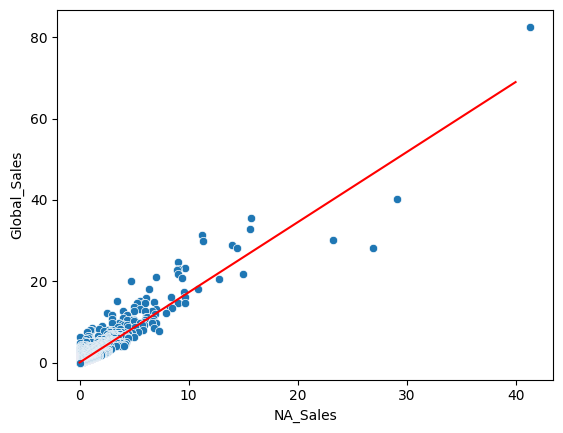

In [121]:
gradient, intercept, mean_abs, mean_squared, rms_error, R2, predictions = compare_to_global_sales(df, 'NA_Sales')


There are 13373 data points in the training set.
There are 3344 data points in the testing set.
Gradient (slope):  0.889701562172356
Intercept:  0.5276432502256121
Mean absolute error:  0.518118657517025
Mean squared error:  2.8205336526250178
Root mean squared error:  1.6794444476150492
R2:  0.3170302347607614


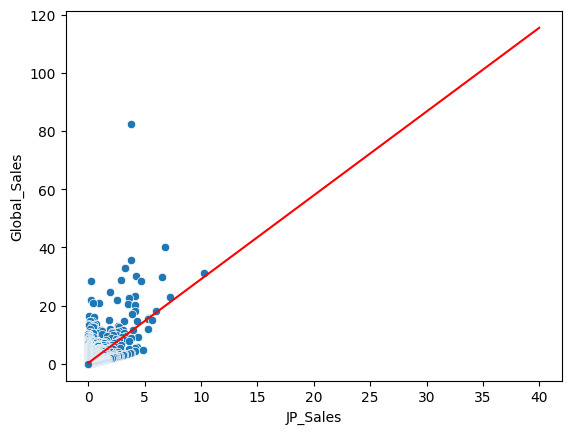

In [122]:
gradient, intercept, mean_abs, mean_squared, rms_error, R2, predictions = compare_to_global_sales(df, 'JP_Sales')


There are 13373 data points in the training set.
There are 3344 data points in the testing set.
Gradient (slope):  1.3838124276884853
Intercept:  0.5345313458126507
Mean absolute error:  0.23892024727582892
Mean squared error:  0.2997851081342117
Root mean squared error:  0.5475263538261987
R2:  0.9274094231302326


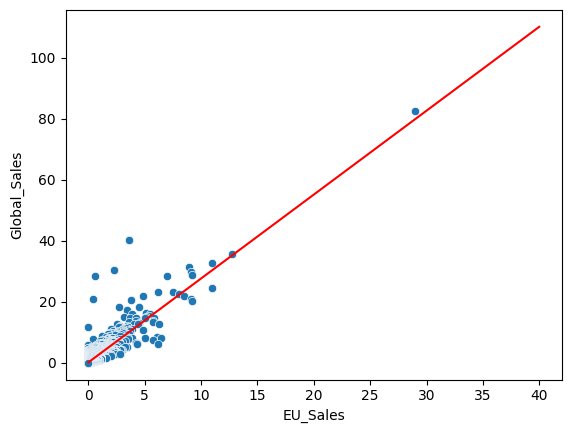

In [123]:
gradient, intercept, mean_abs, mean_squared, rms_error, R2, predictions = compare_to_global_sales(df, 'EU_Sales')


###  Creates a function to predict global sales using multiple input features

In [124]:

def compare_polynomial_to_global_sales(df, input_feature, degree=2):
    # Extract the input feature (e.g., 'NA_Sales') and target ('Global_Sales')
    x = df[input_feature]
    y = df["Global_Sales"]
    x = x.to_numpy().reshape(-1, 1)  # Reshaping to make it 2D for scikit-learn

    # Split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    print("There are %d data points in the training set." % len(x_train))
    print("There are %d data points in the testing set." % len(x_test))

    # Standardize the input feature
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(x)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Apply polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly_train = poly.fit_transform(x_train_scaled)
    x_poly_test = poly.transform(x_test_scaled)

    model = LinearRegression()
    model.fit(x_poly_train, y_train)

    
    coefficients = model.coef_
    intercept = model.intercept_

    print("Coefficients: ", coefficients)
    print("Intercept: ", intercept)

    predictions = model.predict(x_poly_test)

    # Calculates the metrics
    mean_abs = mean_absolute_error(y_test, predictions)
    mean_squared = mean_squared_error(y_test, predictions)
    rms_error = np.sqrt(mean_squared)
    R2 = r2_score(y_test, predictions)

    # Prints the results of these metrics
    print("Mean absolute error: ", mean_abs)
    print("Mean squared error: ", mean_squared)
    print("Root mean squared error: ", rms_error)
    print("R2: ", R2)

    # Prepares a range of x values for plotting the regression curve
    x_fit = np.arange(0, 40, 0.01).reshape(-1, 1)
    x_fit_scaled = scaler.transform(x_fit)
    x_fit_poly = poly.transform(x_fit_scaled)
    y_fit = model.predict(x_fit_poly)

    # Plotting the data and the polynomial regression curve
    sns.scatterplot(data=df, x=input_feature, y="Global_Sales")
    plt.plot(x_fit, y_fit, color='red')  # Plot the polynomial regression curve in red
    plt.xlabel(input_feature)
    plt.ylabel("Global_Sales")
    plt.show()

    return coefficients, intercept, mean_abs, mean_squared, rms_error, R2, predictions


### Call the function

There are 13373 data points in the training set.
There are 3344 data points in the testing set.
Coefficients:  [ 1.60445331 -0.01464988]
Intercept:  0.545071261912417
Mean absolute error:  0.2109651557154825
Mean squared error:  0.6876932288918879
Root mean squared error:  0.8292727108086265
R2:  0.8334805604408264


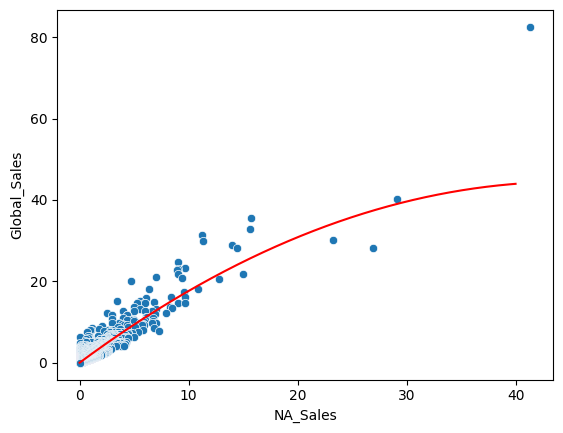

In [125]:
coefficients, intercept, mean_abs, mean_squared, rms_error, R2, predictions = compare_polynomial_to_global_sales(df, 'NA_Sales')


There are 13373 data points in the training set.
There are 3344 data points in the testing set.
Coefficients:  [0.70134167 0.01599357]
Intercept:  0.5113525950945703
Mean absolute error:  0.5153683475477289
Mean squared error:  2.8041237923123004
Root mean squared error:  1.6745518183419408
R2:  0.3210037517705495


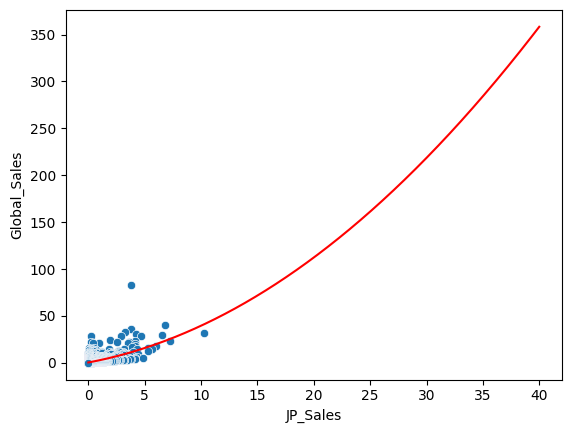

In [126]:
coefficients, intercept, mean_abs, mean_squared, rms_error, R2, predictions = compare_polynomial_to_global_sales(df, 'JP_Sales')

There are 13373 data points in the training set.
There are 3344 data points in the testing set.
Coefficients:  [ 1.39593909e+00 -1.31582335e-03]
Intercept:  0.5356176568836634
Mean absolute error:  0.23965028707631453
Mean squared error:  0.3096153147485125
Root mean squared error:  0.5564308714912505
R2:  0.9250291168724526


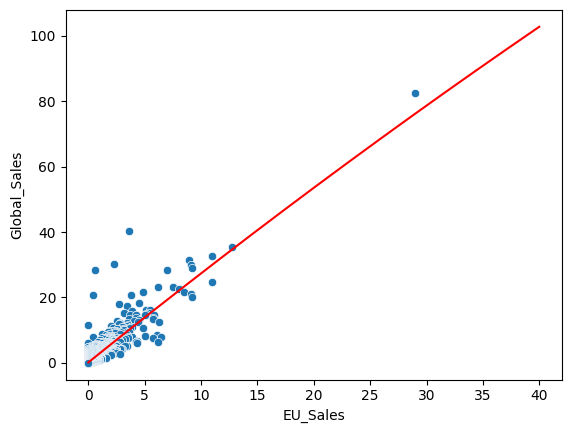

In [127]:
coefficients, intercept, mean_abs, mean_squared, rms_error, R2, predictions = compare_polynomial_to_global_sales(df, 'EU_Sales')


### Regression models that take multiple numerical variables as input features to predict the “global sales”

In [128]:
# Input features and target variable
y = df['Global_Sales']
feature_names = ['NA_Sales', 'JP_Sales', 'EU_Sales']
x = df[feature_names]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train the model
forest_model = RandomForestRegressor(random_state=42, n_estimators=100)
forest_model.fit(X_train, y_train)

# Predictions
yz_pred = forest_model.predict(X_test)

print("Mean absolute error: ", mean_absolute_error(y_test, yz_pred))
print("Mean Squared Error:", mean_squared_error(y_test, yz_pred))
print("Root mean squared error: ", np.sqrt(mean_squared_error(y_test, yz_pred)))
print("R-squared:", r2_score(y_test, yz_pred))

Mean absolute error:  0.048228136289030984
Mean Squared Error: 0.6891709802403021
Root mean squared error:  0.8301632250589652
R-squared: 0.8331227347185313


### Regression models that take multiple variables both categorical and numerical as input features to predict the “global sales”

In [129]:
df2 = df.copy()

y = df2['Global_Sales']
feature_names = ['NA_Sales', 'JP_Sales', 'EU_Sales', 'Genre', 'Rating', 'Platform']
x = df2[feature_names]

# Encode categorical features
for col in ['Genre', 'Platform', 'Rating']:
    df2[col] = LabelEncoder().fit_transform(df2[col].astype(str))

x = df2[feature_names]

# Splits data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train a regression model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict Global Sales
predicted_sales = model.predict(X_test)

# Evaluates the model
print("Mean absolute error: ", mean_absolute_error(y_test, predicted_sales))
print("Mean Squared Error:", mean_squared_error(y_test, predicted_sales))
print("Root mean squared error: ", np.sqrt(mean_squared_error(y_test, predicted_sales)))
print("R-squared:", r2_score(y_test, predicted_sales))


Mean absolute error:  0.04701583510436863
Mean Squared Error: 0.7043551491331871
Root mean squared error:  0.8392586902339392
R-squared: 0.8294460091263813


### BUILDING AN ANN MODEL FOR THE PREDICTION OF GLOBAL SALES

In [131]:
df2 = df.copy()

# Encoding categorical variables using LabelEncoder
for col in ['Genre', 'Platform', 'Rating']:
    df2[col] = LabelEncoder().fit_transform(df2[col].astype(str))

# Scaling numerical features
feature_names = ['NA_Sales', 'JP_Sales', 'EU_Sales', 'Genre', 'Rating', 'Platform']
X = df2[feature_names]
y = df2['Global_Sales']

# SplitS the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data (ANNs typically benefit from standardized inputs)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [66]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

model = Sequential()

# Input layer and 1st hidden layer
model.add(Dense(units=128, activation='relu', input_dim=X_train_scaled.shape[1]))

# 2nd hidden layer
model.add(Dense(units=64, activation='relu'))

# 3rd hidden layer
model.add(Dense(units=32, activation='relu'))

# Output layer
model.add(Dense(units=1))  # No activation function for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test loss: {loss}")
print(f"Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test_scaled)

# Additional performance metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - loss: 0.6124 - mae: 0.1938 - val_loss: 0.0062 - val_mae: 0.0382
Epoch 2/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.0386 - mae: 0.0585 - val_loss: 0.0146 - val_mae: 0.0636
Epoch 3/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0343 - mae: 0.0604 - val_loss: 0.0675 - val_mae: 0.0739
Epoch 4/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0222 - mae: 0.0503 - val_loss: 0.0105 - val_mae: 0.0519
Epoch 5/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0216 - mae: 0.0472 - val_loss: 0.0146 - val_mae: 0.0441
Epoch 6/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0141 - mae: 0.0372 - val_loss: 0.0049 - val_mae: 0.0321
Epoch 7/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0374 - mae: 0.0547 - val_loss: 0.0108 - val_mae: 0.0362
Epoch 8/100
418/418 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0212 - mae: 0.0452 - val_loss: 0.0089 - val_mae: 0.0394
Epoch 9/100
418/418 ━━━━━━━━━━━━

### CREATED A FUNCTION TO PLOT ELBOW GRAPH TO DETERMINE OPTIMAL CLUSTERS

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

def plot_elbow_graph(df, feature_names, max_k=10):
    # Extracting the features from the dataframe
    x = df[feature_names].values
    
    # Standardizing the features
    scale = StandardScaler()
    x_scaled = scale.fit_transform(x)
    
    # Calculating inertia for a range of cluster numbers
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(x_scaled)
        inertia.append(kmeans.inertia_)
    
    # Plotting the elbow graph
    clusters = list(range(1, max_k + 1))
    sns.lineplot(x=clusters, y=inertia, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    
    return inertia




### CREATED A FUNCTION FOR CLUSTERING

In [132]:
def evaluate_clustering(df, feature_names, n_clusters):
    x = df[feature_names].values
    
    # Standardizing the features
    scale = StandardScaler()
    x_scaled = scale.fit_transform(x)
    
    # Fitting KMeans with the specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(x_scaled)
    cluster_labels_pred = kmeans.predict(x_scaled)
    
    # Calculating evaluation metrics
    b_score = metrics.davies_bouldin_score(x_scaled, cluster_labels_pred)
    s_score = metrics.silhouette_score(x_scaled, cluster_labels_pred)
    
    print(f"Davies-Bouldin Score: {b_score}")
    print(f"Silhouette Score: {s_score}")
    
    return b_score, s_score

### CALL THE FUNCTIONS

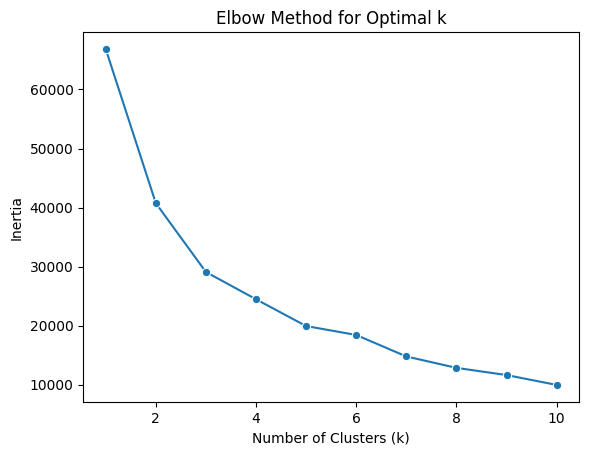

Plot saved as elbow_graph.png


<Figure size 640x480 with 0 Axes>

In [133]:
feature_names = ["NA_Sales", "JP_Sales", "EU_Sales", "Global_Sales"]
inertia_values = plot_elbow_graph(df, feature_names)

# Save the current figure
plt.savefig("elbow_graph.png", dpi=300, bbox_inches='tight')
print("Plot saved as elbow_graph.png")


In [134]:
# Based on the elbow graph, choose an optimal number of clusters (e.g., n_clusters=3)
n_clusters = 3
db_score, silhouette_score = evaluate_clustering(df, feature_names, n_clusters)

print(f"Optimal number of clusters: {n_clusters}")


Davies-Bouldin Score: 0.7968880355760118
Silhouette Score: 0.8546708021233447
Optimal number of clusters: 3


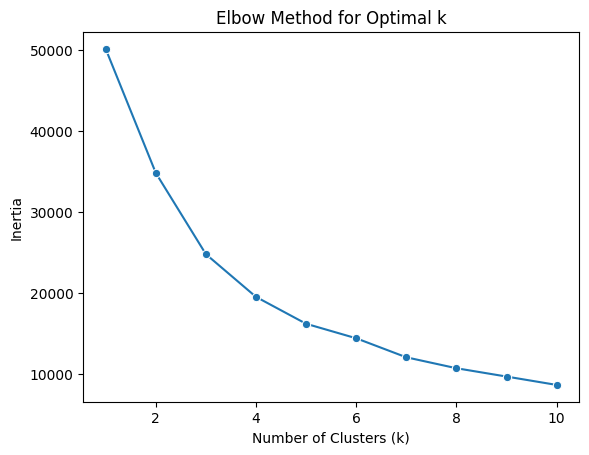

In [135]:
# Assuming df is your dataframe and feature_names is a list of column names
feature_names = ["Critic_Count","User_Count", "Global_Sales"]
inertia_values = plot_elbow_graph(df, feature_names)


In [136]:
# Based on the elbow graph, choose an optimal number of clusters (e.g., n_clusters=3)
n_clusters = 3
db_score, silhouette_score = evaluate_clustering(df, feature_names, n_clusters)

print(f"Optimal number of clusters: {n_clusters}")

Davies-Bouldin Score: 0.9512808074067204
Silhouette Score: 0.6027617243104633
Optimal number of clusters: 3


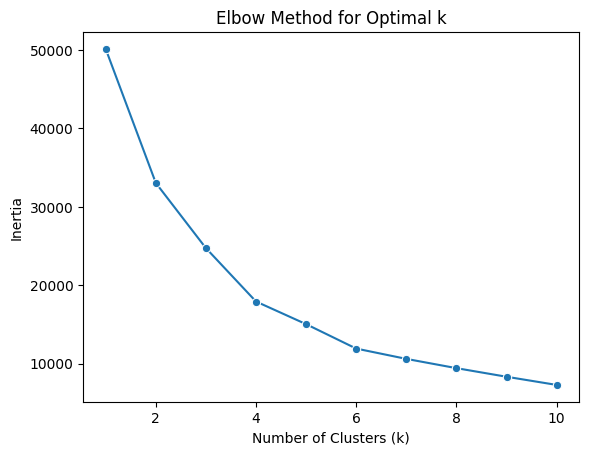

In [137]:
# Assuming df is your dataframe and feature_names is a list of column names
feature_names = ["Critic_Score","User_Score", "Global_Sales"]
inertia_values = plot_elbow_graph(df, feature_names)


In [138]:
# Based on the elbow graph, choose an optimal number of clusters (e.g., n_clusters=3)
n_clusters = 4
db_score, silhouette_score = evaluate_clustering(df, feature_names, n_clusters)

print(f"Optimal number of clusters: {n_clusters}")


Davies-Bouldin Score: 0.8031560463189494
Silhouette Score: 0.3989692307648737
Optimal number of clusters: 4


### CREATED A FUNCTION THAT USES DBSCAN FOR CLUSTERING

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
import pandas as pd

def apply_dbscan(df, eps=0.5, min_samples=3):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Standardize the features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(df_scaled)  # Fit and get cluster labels
    
    # Add cluster labels to the original DataFrame
    df['Cluster'] = cluster_labels
    
    # Filter out outliers (Cluster == -1)
    valid_mask = df['Cluster'] != -1
    valid_scaled = df_scaled[valid_mask]  # Rows corresponding to non-outliers
    valid_clusters = df.loc[valid_mask, 'Cluster']  # Valid cluster labels
    
    # Calculate evaluation metrics if there are at least 2 clusters
    if len(valid_clusters.unique()) > 1:  
        dbs = davies_bouldin_score(valid_scaled, valid_clusters)
        silhouette = silhouette_score(valid_scaled, valid_clusters)
    else:
        dbs = None
        silhouette = None
    
    # Return the updated DataFrame and metrics
    return df, dbs, silhouette




### CALL THE FUNCTION

In [140]:
xl = df[['NA_Sales', 'JP_Sales', 'EU_Sales', 'Global_Sales']]  # Replace with your feature columns
xl_with_clusters, davies_bouldin, silhouette = apply_dbscan(xl)

# Print the metrics
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Silhouette Score: {silhouette}")

Davies-Bouldin Score: 0.5740558050004286
Silhouette Score: 0.6996458800955316


In [141]:
xl = df[["Critic_Count","User_Count", "Global_Sales"]]  # Replace with your feature columns
xl_with_clusters, davies_bouldin, silhouette = apply_dbscan(xl)

# Print the metrics
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Silhouette Score: {silhouette}")

Davies-Bouldin Score: 0.42428837431470395
Silhouette Score: 0.616519343077113


In [142]:
xl = df[["Critic_Score","User_Score", "Global_Sales"]]  # Replace with your feature columns
xl_with_clusters, davies_bouldin, silhouette = apply_dbscan(xl)

# Print the metrics
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Silhouette Score: {silhouette}")

Davies-Bouldin Score: 0.4430799850379421
Silhouette Score: 0.261632682985637


### TABLES FOR EVALUATION

In [12]:
from prettytable import PrettyTable

# Create the table
table = PrettyTable()

# Define the columns
table.field_names = ["Metric", "NA_Sales", "JP_Sales", "EU_Sales"]

# Add rows
table.add_row(["RMSE", 0.536, 1.679,0.548])
table.add_row(["MAE", 0.202, 0.518, 0.239])
table.add_row(["R^2", 0.9304,  1.679, 0.927])
table.add_row(["MSE", 0.287, 2.821, 0.300])    
table.add_row(["Gradient (Slope)", 1.400, 0.890, 1.384])
table.add_row(["Intercept", 0.531, 0.528, 0.535])
# Print the table
title = "LINEAR EVALUATION TABLE"
print(f"\033[1m{title}\033[0m")  # Bold title
print(table)


LINEAR EVALUATION TABLE
+------------------+----------+----------+----------+
|      Metric      | NA_Sales | JP_Sales | EU_Sales |
+------------------+----------+----------+----------+
|       RMSE       |  0.536   |  1.679   |  0.548   |
|       MAE        |  0.202   |  0.518   |  0.239   |
|       R^2        |  0.9304  |  1.679   |  0.927   |
|       MSE        |  0.287   |  2.821   |   0.3    |
| Gradient (Slope) |   1.4    |   0.89   |  1.384   |
|    Intercept     |  0.531   |  0.528   |  0.535   |
+------------------+----------+----------+----------+


In [14]:
# CreateS the table
polytable = PrettyTable()

# DefineS the columns
polytable.field_names = ["Metric", "NA_Sales", "JP_Sales", "EU_Sales"]

# Add rows
polytable.add_row(["RMSE", 0.536, 1.679,0.548])
polytable.add_row(["MAE", 0.211, 0.515, 0.240])
polytable.add_row(["R^2", 0.9304,  1.679, 0.927])
polytable.add_row(["MSE", 0.689, 2.804, 0.310])    
polytable.add_row(["Intercept", 0.545, 0.511, 0.536])
# Print the table
title = "POLYNOMIAL EVALUATION TABLE"
print(f"\033[1m{title}\033[0m")  # Bold title

print(polytable)


POLYNOMIAL EVALUATION TABLE
+-----------+----------+----------+----------+
|   Metric  | NA_Sales | JP_Sales | EU_Sales |
+-----------+----------+----------+----------+
|    RMSE   |  0.536   |  1.679   |  0.548   |
|    MAE    |  0.211   |  0.515   |   0.24   |
|    R^2    |  0.9304  |  1.679   |  0.927   |
|    MSE    |  0.689   |  2.804   |   0.31   |
| Intercept |  0.545   |  0.511   |  0.536   |
+-----------+----------+----------+----------+


In [19]:
table.field_names = ["Metric", "Multiple input Model", "Single Input Model"]

# Add rows to the table based on the given metrics
table.add_row(["Mean Absolute Error (MAE)", 0.0482, 0.2024])
table.add_row(["Mean Squared Error (MSE)", 0.6892, 0.2873])
table.add_row(["Root Mean Squared Error (RMSE)", 0.8302, 0.5360])
table.add_row(["R²", 0.8331, 0.9304])

# Set table style (you can change the style as needed)

# Print the table
print("Model Evaluation Comparison:")
print(table)


Model Evaluation Comparison:
+--------------------------------+----------------------+--------------------+
|             Metric             | Multiple input Model | Single Input Model |
+--------------------------------+----------------------+--------------------+
|   Mean Absolute Error (MAE)    |        0.0482        |       0.2024       |
|    Mean Squared Error (MSE)    |        0.6892        |       0.2873       |
| Root Mean Squared Error (RMSE) |        0.8302        |       0.536        |
|               R²               |        0.8331        |       0.9304       |
+--------------------------------+----------------------+--------------------+


In [20]:
table = PrettyTable()

table.field_names = ["Metric", "Mixed Input Model", "Single Input Model"]

# Add rows to the table based on the given metrics
table.add_row(["Mean Absolute Error (MAE)", 0.0468, 0.2024])
table.add_row(["Mean Squared Error (MSE)", 0.7007, 0.2873])
table.add_row(["Root Mean Squared Error (RMSE)", 0.8371, 0.5360])
table.add_row(["R²", 0.8303, 0.9304])

print("Model Evaluation Comparison:")
print(table)


Model Evaluation Comparison:
+--------------------------------+-------------------+--------------------+
|             Metric             | Mixed Input Model | Single Input Model |
+--------------------------------+-------------------+--------------------+
|   Mean Absolute Error (MAE)    |       0.0468      |       0.2024       |
|    Mean Squared Error (MSE)    |       0.7007      |       0.2873       |
| Root Mean Squared Error (RMSE) |       0.8371      |       0.536        |
|               R²               |       0.8303      |       0.9304       |
+--------------------------------+-------------------+--------------------+


In [22]:

table = PrettyTable()

# Define the field names (columns)
table.field_names = ["Metric", "ANN Model", "Single Input Model"]

# Add rows to the table based on the given metrics
table.add_row(["Test Loss", 0.0045, "N/A"])
table.add_row(["Test MAE", 0.0304, 0.2024])
table.add_row(["Mean Squared Error (MSE)", 0.0045, 0.2873])
table.add_row(["Root Mean Squared Error (RMSE)", 0.0670, 0.5360])
table.add_row(["R²", 0.9989, 0.9304])

# Set table style (you can change the style as needed)

# Print the table
print("Model Evaluation Comparison:")
print(table)


Model Evaluation Comparison:
+--------------------------------+-----------+--------------------+
|             Metric             | ANN Model | Single Input Model |
+--------------------------------+-----------+--------------------+
|           Test Loss            |   0.0045  |        N/A         |
|            Test MAE            |   0.0304  |       0.2024       |
|    Mean Squared Error (MSE)    |   0.0045  |       0.2873       |
| Root Mean Squared Error (RMSE) |   0.067   |       0.536        |
|               R²               |   0.9989  |       0.9304       |
+--------------------------------+-----------+--------------------+


In [24]:
table = PrettyTable()

table.field_names = ["Combination", "Davies-Bouldin Score", "Silhouette Score", "Optimal Clusters"]

# Add rows for each combination
table.add_row(["Combination 1", 0.7969, 0.8547, 3])
table.add_row(["Combination 2", 0.9513, 0.6028, 3])
table.add_row(["Combination 3", 0.8032, 0.3990, 4])

# Set the table style (optional)



# Print the table
print("Clustering Evaluation Results:")
print(table)

Clustering Evaluation Results:
+---------------+----------------------+------------------+------------------+
|  Combination  | Davies-Bouldin Score | Silhouette Score | Optimal Clusters |
+---------------+----------------------+------------------+------------------+
| Combination 1 |        0.7969        |      0.8547      |        3         |
| Combination 2 |        0.9513        |      0.6028      |        3         |
| Combination 3 |        0.8032        |      0.399       |        4         |
+---------------+----------------------+------------------+------------------+


In [86]:
# Create the table
table = PrettyTable()

# Add headers
table.field_names = ["Model", "Davies-Bouldin Score", "Silhouette Score"]

# Add rows
table.add_row(["DBSCAN Model 1", 0.574, 0.699])
table.add_row(["DBSCAN Model 2", 0.424, 0.617])
table.add_row(["DBSCAN Model 3", 0.443, 0.262])

# Print the table
print(table)


+----------------+----------------------+------------------+
|     Model      | Davies-Bouldin Score | Silhouette Score |
+----------------+----------------------+------------------+
| DBSCAN Model 1 |        0.574         |      0.699       |
| DBSCAN Model 2 |        0.424         |      0.617       |
| DBSCAN Model 3 |        0.443         |      0.262       |
+----------------+----------------------+------------------+
